In [16]:
#!pip install alice_ml 

In [ ]:
#!pip install mne

In [37]:
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew , variation
from scipy.signal import welch
import pandas as pd
from scipy.signal import hilbert
import glob
from mne.event import define_target_events
from alice_ml.features import get_features_from_mne
from alice_ml.models import predict_mne

In [38]:
%matplotlib qt

In [39]:
import os

In [40]:
os.chdir('D:/all_eeg/mu_eeg/chernovik_2/resample/NL')

In [41]:
filenames = glob.glob('*_NL_1.fif') #смотрим весь список 
filenames

['NP102302_NL_1.fif',
 'NP102303_NL_1.fif',
 'NP102304_NL_1.fif',
 'NP102305_NL_1.fif',
 'NP102306_NL_1.fif',
 'NP102307_NL_1.fif',
 'NP102308_NL_1.fif',
 'NP102309_NL_1.fif',
 'NP102310_NL_1.fif',
 'NP102311_NL_1.fif',
 'NP102312_NL_1.fif',
 'NP102313_NL_1.fif',
 'NP102314_NL_1.fif',
 'NP102315_NL_1.fif',
 'NP112301_NL_1.fif',
 'NP112302_NL_1.fif',
 'NP112303_NL_1.fif',
 'NP112304_NL_1.fif',
 'NP112306_NL_1.fif',
 'NP112307_NL_1.fif',
 'NP112308_NL_1.fif',
 'NP112309_NL_1.fif',
 'NP112310_NL_1.fif',
 'NP112311_NL_1.fif',
 'NP112313_NL_1.fif',
 'NP112314_NL_1.fif',
 'NP112315_NL_1.fif',
 'NP112316_NL_1.fif',
 'NP112317_NL_1.fif',
 'NP112318_NL_1.fif',
 'NP112319_NL_1.fif',
 'NP112320_NL_1.fif',
 'NP112321_NL_1.fif',
 'NP112322_NL_1.fif',
 'NP122301_NL_1.fif',
 'NP122302_NL_1.fif',
 'NP122303_NL_1.fif']

In [42]:
filenames = glob.glob('NP112314_NL_1.fif') #выбираем нужный нам NP 
filenames

['NP112314_NL_1.fif']

In [43]:
ID=filenames[0]#выираем  
ID

'NP112314_NL_1.fif'

In [44]:
name = ID #видео с руками перед 

E = mne.io.read_raw_fif(name, preload = True)
E = E.drop_channels(['Photo', 'micr'])  
E = E.filter(1, 70, phase='zero-double')




Opening raw data file NP112314_NL_1.fif...
    Range : 0 ... 296379 =      0.000 ...   592.758 secs
Ready.
Reading 0 ... 296379  =      0.000 ...   592.758 secs...


C:\Users\chuba\AppData\Local\Temp\ipykernel_7616\509579773.py:3: RuntimeWarning: This filename (NP112314_NL_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  E = mne.io.read_raw_fif(name, preload = True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 70 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-12 dB cutoff frequency: 78.75 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.7s finished


In [45]:
#смотрим метки 
events=mne.events_from_annotations(E) 

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Stimulus/S  1', 'Stimulus/S 11', 'Stimulus/S 13']


In [46]:
#рисуем метки 
fig=mne.viz.plot_events(events[0])
plt.show()

In [47]:
events[0]

array([[     0,      0,  99999],
       [ 22581,      0,      1],
       [ 23103,      0,     13],
       [169788,      0,   1001],
       [172640,      0,  99999],
       [181721,      0,      1],
       [182224,      0,      1],
       [203871,      0,     11],
       [294991,      0,   1001]])

In [48]:
#выбираем мекту 13 (начало ежа)
print(events[0][2])

[23103     0    13]


In [49]:
#обрезаем нужный нам фрагмент s13 точка старта + 292с (время сказки про ежей)

start = events[0][2][0]/500
hedgehog_eeg = E.copy().crop(tmin = start, tmax = start + 292)

In [50]:
#НАЧИНАЕМ ПРЕДОБРАБОТКУ, смотрим каналы 
print(hedgehog_eeg.info['ch_names'])

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']


In [52]:
#удаляем плохие сегменты и плохие каналы 
fig = hedgehog_eeg.plot(n_channels=len(E.ch_names))
fig.fake_keypress('a')

Channels marked as bad:
none


In [53]:
#смотрим плохие каналы
print(ID)
print(hedgehog_eeg.info['bads'])

NP112314_NL_1.fif
[]


In [54]:
#интерполяция плохих каналов 
hedgehog_eeg = hedgehog_eeg.interpolate_bads(reset_bads=True, method=dict(eeg='MNE'), verbose=True)#reset_bads значит что после интерполяция он обнулит список плохих каналов 

C:\Users\chuba\AppData\Local\Temp\ipykernel_7616\1689106075.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  hedgehog_eeg = hedgehog_eeg.interpolate_bads(reset_bads=True, method=dict(eeg='MNE'), verbose=True)#reset_bads значит что после интерполяция он обнулит список плохих каналов


In [55]:
#начинаем ica 
ica = ICA(n_components=20, random_state=97) # Создаем объект ICA. Первым аргументом данной фунции является число компонент, на которые хотим разложить наш сигнал
ica.fit(hedgehog_eeg, reject_by_annotation=True) # Даем алгоритму возможность отыскать значения весов для ICA.

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.1s.


<ICA | raw data decomposition, method: fastica (fit in 54 iterations on 146001 samples), 20 ICA components (31 PCA components available), channel types: eeg, no sources marked for exclusion>

In [56]:
#подсказка от ALICE 
table = predict_mne(hedgehog_eeg, ica)
table['flag_brain'] = table['flag_brain'].round(6)
table


D:\programm\prog file\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\programm\prog file\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\programm\prog file\anaconda\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.0.2. This might lead to breaking c

flag_brain  flag_muscles  flag_eyes
ICA000    0.000000      0.000011   1.000000
ICA001    0.000000      0.005918   1.000000
ICA002    0.331556      0.043886   0.106085
ICA003    0.475250      0.047630   0.035136
ICA004    0.416442      0.030681   0.041173
ICA005    0.412862      0.064047   0.122316
ICA006    0.001084      0.036072   0.899766
ICA007    0.002259      0.109722   0.982275
ICA008    0.539639      0.037908   0.057366
ICA009    0.571398      0.030749   0.087250
ICA010    0.349674      0.150207   0.118734
ICA011    0.305587      0.125790   0.100779
ICA012    0.001254      0.997986   0.130207
ICA013    0.026140      0.963280   0.085801
ICA014    0.136193      0.756846   0.109004
ICA015    0.341739      0.057896   0.106374
ICA016    0.109811      0.843684   0.100381
ICA017    0.098634      0.713630   0.110000
ICA018    0.022599      0.985676   0.068345
ICA019    0.037313      0.956051   0.098692

In [58]:
ica.plot_components(picks=range(20), inst=hedgehog_eeg, title=ID)
ica.plot_sources(inst = hedgehog_eeg)
plt.show()
    

Creating RawArray with float64 data, n_channels=20, n_times=146001
    Range : 23103 ... 169103 =     46.206 ...   338.206 secs
Ready.


In [59]:
ica

<ICA | raw data decomposition, method: fastica (fit in 54 iterations on 146001 samples), 20 ICA components (31 PCA components available), channel types: eeg, 8 sources marked for exclusion>

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 8 ICA components
    Projecting back using 31 PCA components


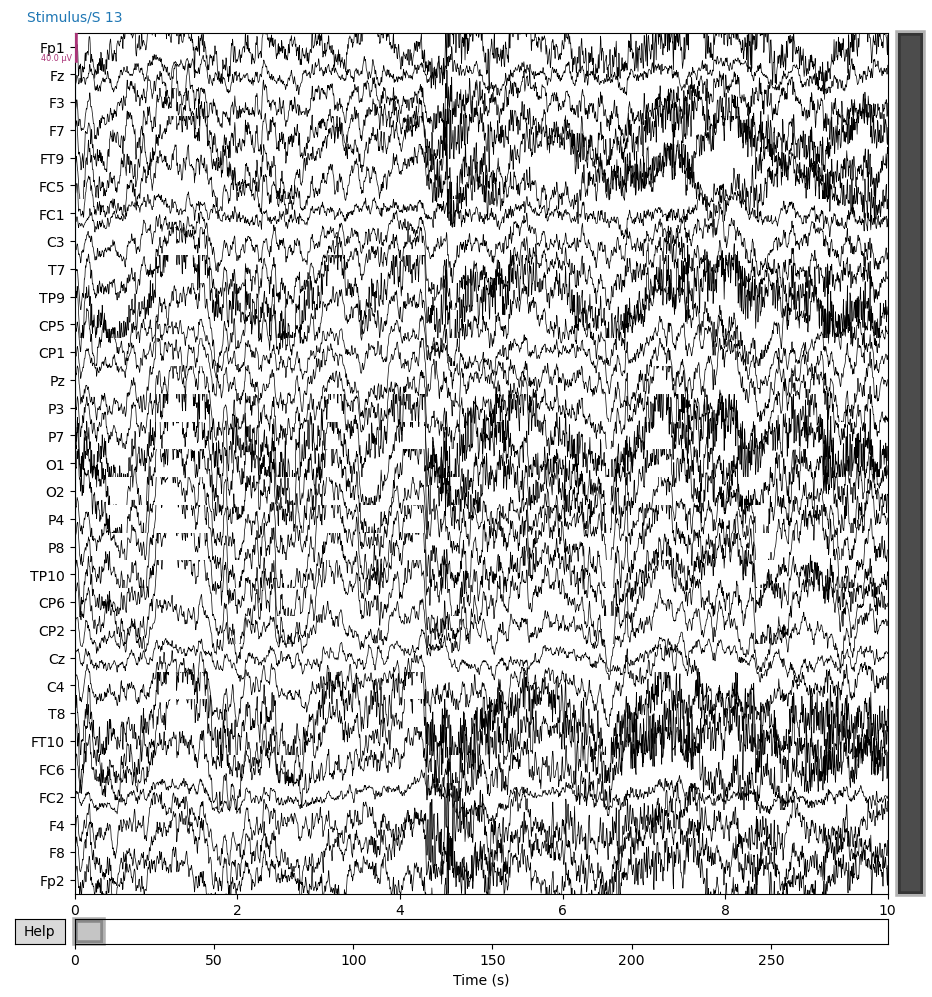

Channels marked as bad:
none


In [60]:
ica.exclude #Задаем этот список, как одно из полей класса
#raw_data_to_check=raw_data.copy()
ica.apply(hedgehog_eeg)
hedgehog_eeg.plot(start=0, n_channels=len(hedgehog_eeg.ch_names)) 

In [61]:
#ререференсинг 
hedgehog_eeg.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<Raw | NP112314_NL_1.fif, 31 x 146001 (292.0 s), ~34.6 MB, data loaded>

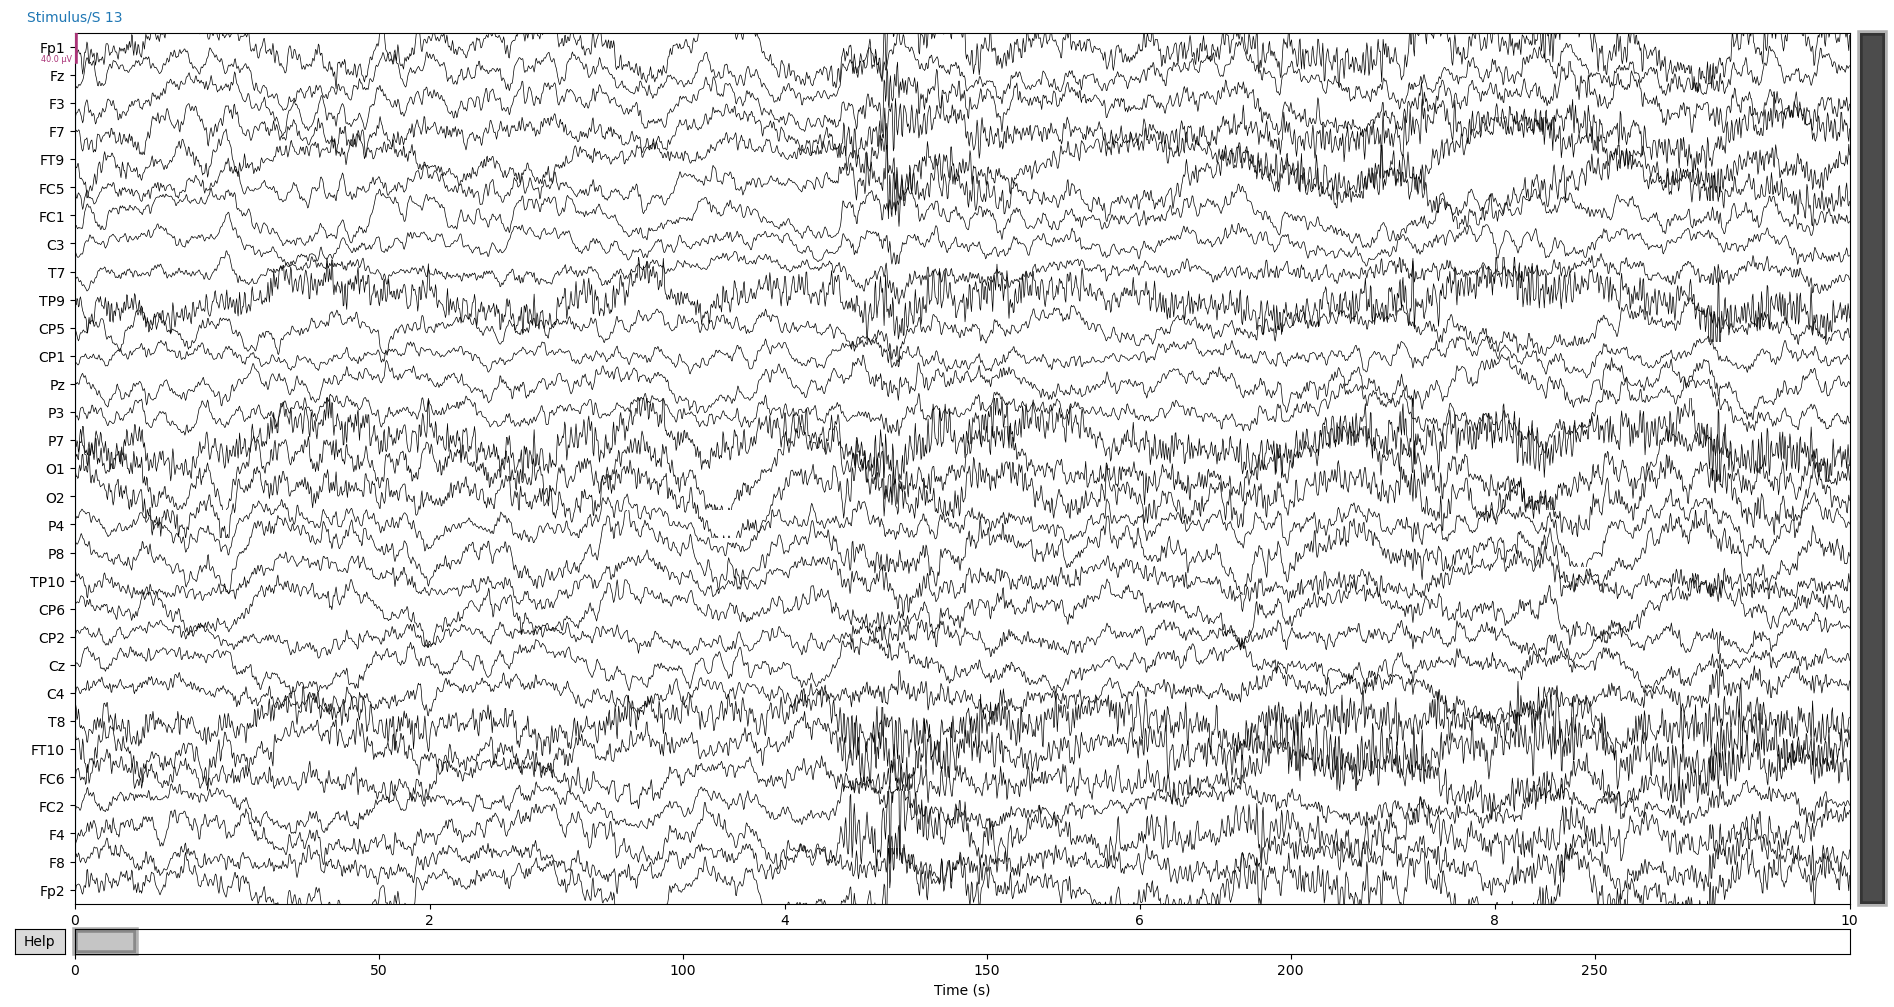

Channels marked as bad:
none


In [62]:
#смортим после ререференсинга 
hedgehog_eeg.plot(start=0, n_channels=len(hedgehog_eeg.ch_names)) 

In [72]:
ID_HG = ID.rstrip('.fif')
print(ID_HG)

NP112314_NL_1


In [69]:
#сохраняем записи НЕ ЭПОХИ D:\all_eeg\mu_eeg\chernovik_2\HG preproc
folder = "D:/all_eeg/mu_eeg/chernovik_2/HG preproc/" #путь сохарнения 
hedgehog_eeg.save(folder + ID_HG + '_hg.fif', overwrite=True)


Writing D:\all_eeg\mu_eeg\chernovik_2\HG preproc\NP112314_NL_1_hg.fif


C:\Users\chuba\AppData\Local\Temp\ipykernel_7616\287473964.py:3: RuntimeWarning: This filename (D:\all_eeg\mu_eeg\chernovik_2\HG preproc\NP112314_NL_1_hg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  hedgehog_eeg.save(folder + ID_HG + '_hg.fif', overwrite=True)


Closing D:\all_eeg\mu_eeg\chernovik_2\HG preproc\NP112314_NL_1_hg.fif
[done]


# ПРИСТУПЕАМ К РАБОТЕ С ЭПОХАМИ 

In [73]:
#формирование эпох по 2 секунды и автоматическое удаление плохих эпох
threshold = 360e-6 #порого - отткуда велчина? (у Гургена 350e-6)
epochs_hedgehog_eeg = mne.make_fixed_length_epochs(hedgehog_eeg, duration=2.0, preload=False, reject_by_annotation=True, proj=True, overlap=0.0, id=1, verbose=None)
data_hedgehog_eeg = epochs_hedgehog_eeg.drop_bad(reject=dict(eeg=threshold))

Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 146 events and 1000 original time points ...
0 bad epochs dropped


C:\Users\chuba\AppData\Local\Temp\ipykernel_7616\2217874202.py:2: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  data_hedgehog_eeg.plot(n_channels=len(data_hedgehog_eeg.ch_names))


Using data from preloaded Raw for 20 events and 1000 original time points ...


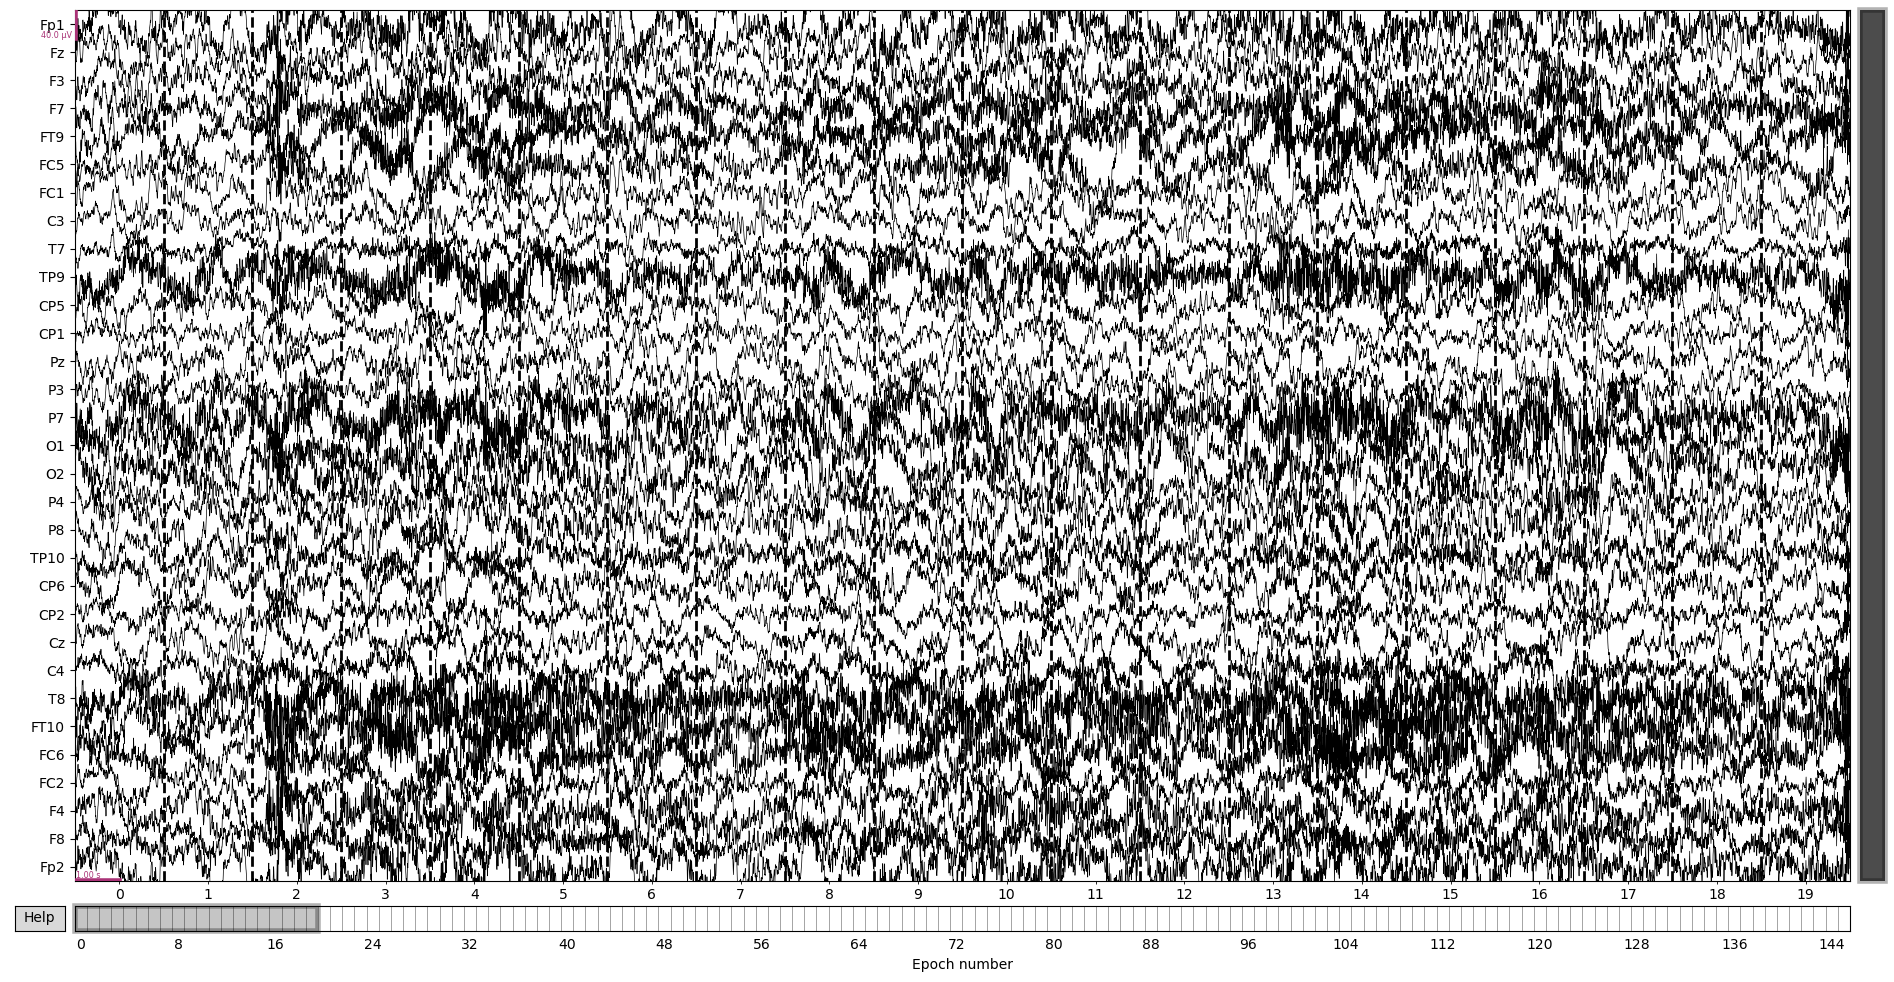

Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Using data from preloaded Raw for 20 events and 1000 original time points ...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [76]:
#провереям результат 
data_hedgehog_eeg.plot(n_channels=len(data_hedgehog_eeg.ch_names))

In [79]:
#сохраняем записи ЭПОХИ 
folder = "D:/all_eeg/mu_eeg/chernovik_2/HG preproc/" #путь сохарнения 
hedgehog_eeg.save(folder + ID_HG + '_hg_epoch.fif', overwrite=True)

Writing D:\all_eeg\mu_eeg\chernovik_2\HG preproc\NP112314_NL_1_hg_epoch.fif
Closing D:\all_eeg\mu_eeg\chernovik_2\HG preproc\NP112314_NL_1_hg_epoch.fif


C:\Users\chuba\AppData\Local\Temp\ipykernel_7616\4245835289.py:3: RuntimeWarning: This filename (D:\all_eeg\mu_eeg\chernovik_2\HG preproc\NP112314_NL_1_hg_epoch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  hedgehog_eeg.save(folder + ID_HG + '_hg_epoch.fif', overwrite=True)


[done]
